# Pandas Time series with Election Data
## Exploratory Data Analysis examples - Part 2
For a lecture on Python tools for data scientists, I prepared few data used cases, to demonstrate pandas,numpy and matplotlib functionality. 
In this tutorial, US Election data is used. The data is published by the Federal Election Commission, and can be downloaded here: https://www.fec.gov
The election data website, contain many data sets, with election information. Data about Candidates, Committees, fund raising transactions, contributors information, etc.

In [492]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Candidate data

Download Form2Filer_2018.csv.  
* https://www.fec.gov/data/advanced/?tab=candidates

In [493]:
df_cand = pd.read_csv('Form2Filer_2018.csv')
df_cand.head()

,CANDIDATE_ID,CANDIDATE_NAME,PARTY,PARTY_CODE,CANDIDATE_OFFICE,CANDIDATE_OFFICE_CODE,CANDIDATE_OFFICE_STATE,CANDIDATE_OFFICE_STATE_CODE,CANDIDATE_OFFICE_DISTRICT,CITY,STATE,ZIP,ELECTION_YEAR,RECEIPT_DATE,REPORT_YEAR,BEGIN_IMAGE_NUMBER
0,H8DC00192,"CHEEKS, JOHN C",Independent American Party,IAP,House,H,District Of Columbia,DC,0.0,WASHINGTON,DC,20007.0,2018,18-OCT-18,2018,201810180300238682
1,H8NJ07256,"MOXLEY, DIANE",Green Party,GRE,House,H,New Jersey,NJ,7.0,GARWOOD,NJ,7027.0,2018,17-OCT-18,2018,201810170300237429
2,S8RI00177,"COSTA, MICHAEL",Independent,IND,Senate,S,Rhode Island,RI,0.0,BRISTOL,RI,28099998.0,2018,16-OCT-18,2018,201810169125548990
3,H8PA16094,"BEEMAN, EBERT GORDAN",Libertarian Party,LIB,House,H,Pennsylvania,PA,16.0,ERIE,PA,16510.0,2018,13-OCT-18,2018,201810139124739087
4,H8MD04239,"BISHOP, DAVID ANTHONY DARK HORSE",Libertarian Party,LIB,House,H,Maryland,MD,4.0,ARNOLD,MD,21012.0,2018,12-OCT-18,2018,201810129124516955


### Filter Candidate data 
Lets focus only on 2018 election to the congress. Meaning, we select only the data with the following features.
* ELECTION_YEAR: 2018
* CANDIDATE_OFFICE: House or Senate

In [494]:
print(len(df_cand))
election_year_2018 = (df_cand['ELECTION_YEAR'] == 2018 )
congress_candidate = ~(df_cand['CANDIDATE_OFFICE'] == 'President')
df_cand = df_cand[election_year_2018 & congress_candidate]
print(len(df_cand))

3148
3041


Filter only relevant columns

In [495]:
cols = ['CANDIDATE_ID' ,'CANDIDATE_NAME', 'PARTY', 'PARTY_CODE', 'STATE',
        'CANDIDATE_OFFICE']
df_cand = df_cand[cols]

### Manage Missing values
Check missing values with info() pandas method.

In [496]:
df_cand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3041 entries, 0 to 3147
Data columns (total 6 columns):
CANDIDATE_ID        3041 non-null object
CANDIDATE_NAME      3041 non-null object
PARTY               3041 non-null object
PARTY_CODE          3036 non-null object
STATE               3038 non-null object
CANDIDATE_OFFICE    3041 non-null object
dtypes: object(6)
memory usage: 166.3+ KB


In [497]:
df_cand[df_cand['PARTY_CODE'].isnull()].head(6)

,CANDIDATE_ID,CANDIDATE_NAME,PARTY,PARTY_CODE,STATE,CANDIDATE_OFFICE
5,S8ME00171,"RILEY JR, JAMES N",Unknown,NaN,NaN,Senate
14,S8OH00144,"FARIS, STEPHEN I MR",Unknown,NaN,OH,Senate
492,S8MN00628,"PAINTER, RICHARD",Unknown,NaN,MN,Senate
1208,H8MD03116,"DEMARCO , ADAM D.",Unknown,NaN,NaN,House
2467,S8CA00325,"ADAMS, DONALD R",Unknown,NaN,CA,Senate


In [498]:
len(df_cand[df_cand['PARTY']=='Unknown'])

23

Number of candidates missing party values is small, so we delete them with `drop` pandas function.

In [499]:
drop_cand = df_cand.PARTY_CODE.isnull() | (df_cand['PARTY']=='Unknown')
df_cand = df_cand.drop(df_cand[drop_cand].index)

### Explore Party data

To visualize number of candidates per party, we use pandas  `values_count()` method on `PARTY_CODE` column, and plot it as bar plot.

Text(0.5,1,'Candidates by Party')

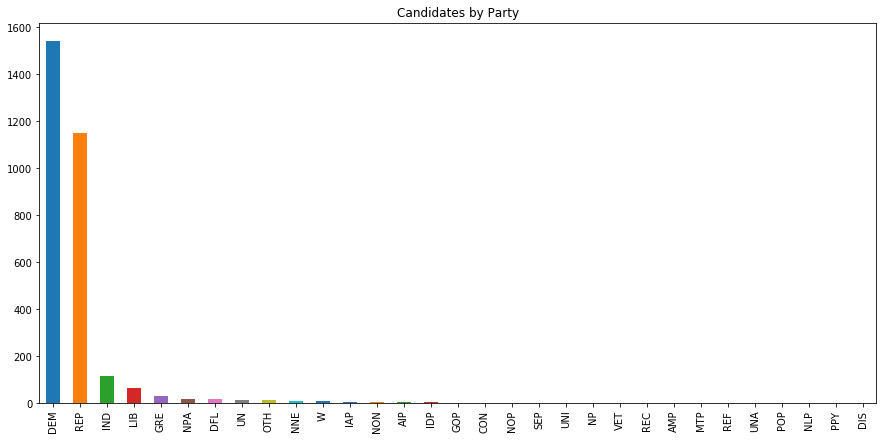

In [500]:
ax = df_cand.PARTY_CODE.value_counts().plot(kind='bar', figsize=(15,7))
ax.set_title('Candidates by Party')

Lets bin all values of parties with small amount of candidates to one category, `Other`. To do that, we build a list of the relevant parties names, then use `apply` pandas function, to map all other party name values to `Other`.

In [501]:
party_vals = df_cand.PARTY.value_counts()
big_party_names = [x for x in party_vals.index if party_vals[x]>30]
def map_parties(p):
    if p not in big_party_names:
        return 'Other'
    return p
df_cand.PARTY = df_cand.PARTY.apply(map_parties)
df_cand.head()

,CANDIDATE_ID,CANDIDATE_NAME,PARTY,PARTY_CODE,STATE,CANDIDATE_OFFICE
0,H8DC00192,"CHEEKS, JOHN C",Other,IAP,DC,House
1,H8NJ07256,"MOXLEY, DIANE",Green Party,GRE,NJ,House
2,S8RI00177,"COSTA, MICHAEL",Independent,IND,RI,Senate
3,H8PA16094,"BEEMAN, EBERT GORDAN",Libertarian Party,LIB,PA,House
4,H8MD04239,"BISHOP, DAVID ANTHONY DARK HORSE",Libertarian Party,LIB,MD,House


Text(0.5,1,'Candidates by Party')

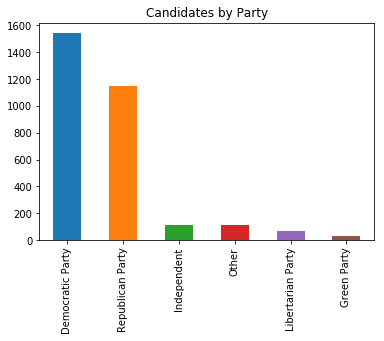

In [502]:
ax = df_cand.PARTY.value_counts().plot(kind='bar')
ax.set_title('Candidates by Party')

To visualize candidate distribution, per party and per office, group by party, and count in each group, number of Senate candidates. Then unstack the result, to _flip_ the table, so party column, becomes feature labels. To plot "transformed" bar plot, we use `kind=barh` parameter value.

In [503]:
df_cand.groupby('PARTY').CANDIDATE_OFFICE.value_counts()[0:5]

PARTY             CANDIDATE_OFFICE
Democratic Party  House               1429
                  Senate               114
Green Party       House                 24
                  Senate                 7
Independent       House                 86
Name: CANDIDATE_OFFICE, dtype: int64

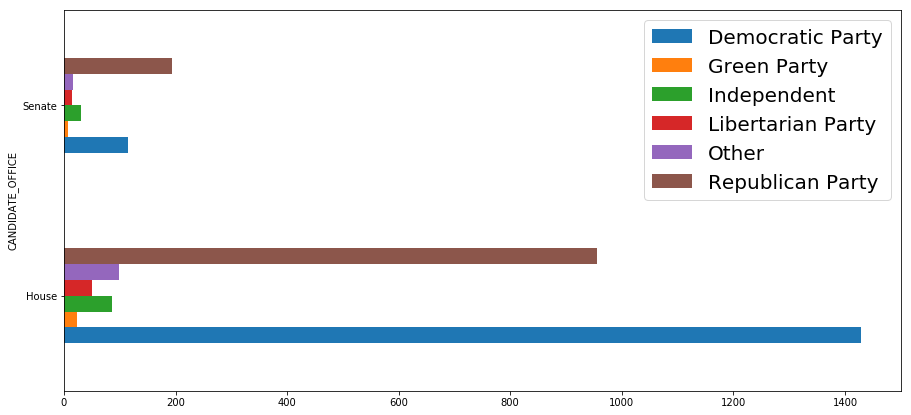

In [504]:
df_cand.groupby('PARTY').CANDIDATE_OFFICE.value_counts().unstack(0).plot(kind='barh', figsize=(15,7))
plt.legend( loc='upper right',fontsize=20)

For simplicity, delete all candidates with PARTY different than Republican or Democratic. 

In [505]:
rep_dem = (df_cand.PARTY_CODE == 'REP') | (df_cand.PARTY_CODE == 'DEM')
print(len(df_cand[rep_dem])*100./len(df_cand))
df_cand = df_cand[rep_dem].reset_index(drop=True)

89.16500994035785


## Contribution data
Contribution data contains all transaction related to election fundraising. Data is separated to contribution from committees and contribution from individuals and organizations. We will use the Contributions by individuals data files. 
The header for those files is kept in a separate csv file. Feature description here: https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/

In [506]:
df_contr_head = pd.read_csv('indiv_header_file.csv')

Lets view the following features: 

**ENTITY_TP** - The type of contributing entity, values are:
- CCM = Candidate Committee
- COM = Committee 
- IND = Individual (a person)
- ORG = Organization (not a committee and not a person)
- PAC = Political Action Committee
- PTY = Party Organization

**TRANSACTION_DT**: Transaction date (MMDDYYYY)

**TRANSACTION_AMT**:	Transaction amount

**OCCUPATION** and **EMPLOYER** - Contributor features.

Data files are big, so for demonstration,we will sample from each file 1% of it's content, and concatenate it into one data frame.
* Files downloaded from https://www.fec.gov/data/advanced/?tab=bulk-data
If you download full data, you can use the following code, if you download sample code from my github, jump forward.

In [507]:
SAMPLE_CODE =True

In [508]:
import os
if not SAMPLE_CODE:
    directory = os.path.join('indiv18', 'by_date')
    data_files = os.listdir(directory)
    
    dateparse = lambda x: pd.datetime.strptime(x, '%m%d%Y')
    
    p = 0.01  # 1% of the raws
    
    file = os.path.join(directory, data_files[0])
    df_contr = pd.read_csv(file,
                          delimiter='|', names=df_contr_head.columns,
                          usecols=['OCCUPATION', 'CMTE_ID', 'TRANSACTION_DT',
                                   'EMPLOYER','ENTITY_TP', 'TRANSACTION_AMT'],
                          parse_dates=['TRANSACTION_DT'], date_parser=dateparse,
             skiprows=lambda i: i>0 and np.random.random() > p)
    df_contr.head()

Lets list the downloaded data files.

In [509]:
 if not SAMPLE_CODE:
        os.listdir(directory)[1:]

The last file have invalid date data, so we ignor it.

In [510]:
if not SAMPLE_CODE:
    print('Data number of rows:', len(df_contr))
    for x in data_files[1:-1]:
        file = os.path.join(directory, x)
        print('Loading: ', x)
        df = pd.read_csv(file,
                          delimiter='|', names=df_contr_head.columns,
                          usecols=['OCCUPATION', 'CMTE_ID', 'TRANSACTION_DT',
                                   'EMPLOYER','ENTITY_TP', 'TRANSACTION_AMT'],
                          parse_dates=['TRANSACTION_DT'], date_parser=dateparse,
             skiprows=lambda i: i>0 and np.random.random() > p)
        df_contr = pd.concat([df_contr,df], axis=0)
        print('Data number of rows:', len(df_contr))

Save the sampled file. 

In [511]:
if not SAMPLE_CODE:
    df_contr.to_csv(os.path.join(directory,
                                'sampled_itcont_2018.csv'), index=False)

Read the sampled data file, and pars dates to datetime object.

In [512]:
if SAMPLE_CODE:
    sam_dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    df_contr = pd.read_csv('sampled_itcont_2018.csv',
                      parse_dates=['TRANSACTION_DT'], date_parser=sam_dateparse)

In [513]:
df_contr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138238 entries, 0 to 138237
Data columns (total 6 columns):
CMTE_ID            138238 non-null object
ENTITY_TP          138193 non-null object
EMPLOYER           123026 non-null object
OCCUPATION         130417 non-null object
TRANSACTION_DT     138238 non-null datetime64[ns]
TRANSACTION_AMT    138238 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 6.3+ MB


In [514]:
df_contr.head()

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT
0,C00629618,IND,PRINCIPAL,DOUBLE NICKEL ADVISORS,2017-01-03,40
1,C00473249,IND,NaN,RETIRED,2017-01-20,500
2,C00397455,IND,PHARMERICA,CEO,2017-01-20,192
3,C00264689,IND,USPS,LETTER CARRIER,2017-01-18,250
4,C00139659,IND,SELF EMPLOYED,TRAVEL AGENT,2017-01-10,250


Rename columns with very long names 

In [515]:
df_contr = df_contr.rename(columns={'TRANSACTION_DT': 'Date', 'TRANSACTION_AMT': 'Amount'})

## Some Feature engineering

### Explore contribution type
View number of entries per each category of entity type.

In [516]:
df_contr.ENTITY_TP.value_counts()

IND    137891
ORG       141
CAN       132
PAC        23
CCM         3
COM         2
PTY         1
Name: ENTITY_TP, dtype: int64

We will focus only on on contributions from individuals and organizations.To be sure we are not missing important data,lets visualize contribution amount aggregation by entity type.

Text(0.5,1,'Contribution amount per contribution type')

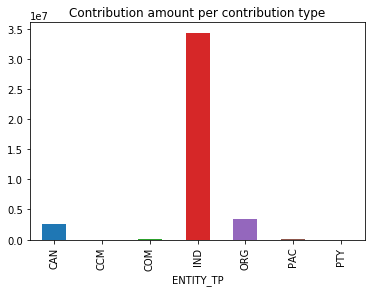

In [517]:
ax = df_contr.groupby('ENTITY_TP')['Amount'].sum().plot(kind='bar')
ax.set_title('Contribution amount per contribution type')

Same as before, for simplicity, filter only contributions from individual.

In [518]:
df_contr = df_contr[(df_contr['ENTITY_TP']=='IND')]

### Explore EMPLOYER and OCCUPATION features
These features have many unique values. To simplify things, lets try to analyze who is working, and create new 0,1 column: `work`. 
> If EMPLOYER and OCCUPATION are Null, we set `work` to be zero.
Lets dive into the case when OCCUPATION is Null and  EMPLOYER is not null.


In [519]:
tmp=df_contr[df_contr['OCCUPATION'].isnull() & ~df_contr['EMPLOYER'].isnull()]
tmp['EMPLOYER'].value_counts()[0:5]

NONE                        121
SELF-EMPLOYED                65
RETIRED                      25
SBC - SOUTH WESTERN BELL     25
ATT MOBILITY/ CINGULAR       13
Name: EMPLOYER, dtype: int64

We can see that NONE string is used in some rows instead of Null value. Lets change all Null values to NONE string, with fillna function.

In [520]:
df_contr[['OCCUPATION', 'EMPLOYER']] = df_contr[['OCCUPATION', 'EMPLOYER']].fillna('NONE');

Lets view the most common `OCCUPATION` values in this situation.

In [521]:
tmp = df_contr[(df_contr['EMPLOYER']=='NONE') & (df_contr['OCCUPATION'] != 'NONE')]
tmp.OCCUPATION.value_counts()[0:5]

RETIRED              6094
NOT EMPLOYED         5908
UNEMPLOYED           1443
HOMEMAKER             325
RETIRED PROFESSOR      56
Name: OCCUPATION, dtype: int64

Let's bin a few common values together.
* To identify the self-employed, we check id 'SELF' string is a substring of Employer.
* To identify the retired, we check if a version of retired is a substring of occupation.

In [522]:
def bin_occupation(x):
    
    if ('SELF' in str(x)):
        return 'SELF EMPLOYED'
    if (('RETIRED' in str(x)) or ('REETIRED' in str(x))):
        return 'RETIRED'
    return x
df_contr['OCCUPATION'] = df_contr['OCCUPATION'].apply(bin_occupation)

In [523]:
tmp = df_contr[(df_contr['EMPLOYER']=='NONE') & (df_contr['OCCUPATION'] != 'NONE')]
tmp.OCCUPATION.value_counts()[0:7]

RETIRED          6342
NOT EMPLOYED     5908
UNEMPLOYED       1443
HOMEMAKER         325
SELF EMPLOYED     101
DISABLED           42
HOUSEWIFE          20
Name: OCCUPATION, dtype: int64

We can see that most contributors with NONE value are self-employed or not working. Based on this, we can create work mapping function. It's not accurate but cover the common cases.<br>
To apply a function on each row, we use apply data frame method with parameter `axis=1`.

In [524]:
def is_working(x):
    
    if (x['OCCUPATION']=='NONE') and (x['EMPLOYER']=='NONE'):
        return 0
    if (x['EMPLOYER']=='NONE'):
        if (str(x['OCCUPATION']) == 'SELF EMPLOYED'):
            return 1
        else:
            return 0
    return 1
    
df_contr['Work'] = df_contr.apply(is_working, axis=1)

In [525]:
df_contr[(df_contr['EMPLOYER']=='NONE') & (df_contr['Work']==1)].head()

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,Date,Amount,Work
1302,C00629378,IND,NONE,SELF EMPLOYED,2017-02-07,80,1
5032,C00401224,IND,NONE,SELF EMPLOYED,2017-05-20,1,1
5033,C00401224,IND,NONE,SELF EMPLOYED,2017-05-20,1,1
5046,C00401224,IND,NONE,SELF EMPLOYED,2017-05-27,90,1
9511,C00424713,IND,NONE,SELF EMPLOYED,2017-01-06,50,1


In [526]:
#df_contr = df_contr.drop(['EMPLOYER'], axis=1).reset_index(drop=True)

In [527]:
len(df_contr[df_contr.Work==1])/len(df_contr)

0.8211993531122408

### Explore Amount of transaction feature


In [528]:
df_contr.Amount.describe()

count    1.378910e+05
mean     2.490665e+02
std      1.489228e+04
min     -2.000000e+04
25%      1.500000e+01
50%      3.500000e+01
75%      1.000000e+02
max      5.402259e+06
Name: Amount, dtype: float64

In [529]:
df_contr.head()

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,Date,Amount,Work
0,C00629618,IND,PRINCIPAL,DOUBLE NICKEL ADVISORS,2017-01-03,40,1
1,C00473249,IND,NONE,RETIRED,2017-01-20,500,0
2,C00397455,IND,PHARMERICA,CEO,2017-01-20,192,1
3,C00264689,IND,USPS,LETTER CARRIER,2017-01-18,250,1
4,C00139659,IND,SELF EMPLOYED,TRAVEL AGENT,2017-01-10,250,1


In [530]:
df_contr =  df_contr[df_contr.Amount > 0]
df_contr.describe()

,Amount,Work
count,1.308790e+05,130879.000000
mean,2.668141e+02,0.843336
std,1.528541e+04,0.363485
min,1.000000e+00,0.000000
25%,1.800000e+01,1.000000
50%,3.900000e+01,1.000000
75%,1.000000e+02,1.000000
max,5.402259e+06,1.000000


## Committee data
Contribution data is organized by committee, so we need to link each committee to the suitable candidate. File contain a lot of information, we will read only the id columns.

In [531]:
df_committee = pd.read_csv('committee_summary_2018.csv',
                           usecols=['CMTE_ID', 'CAND_ID'])

Select only data rows with non null candidate id.

In [532]:
df_committee = df_committee[~df_committee['CAND_ID'].isnull()]

Merge contributor data with committee data to associate each contribution with candidate and party. <br>
* Read more: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html

In [533]:
df_merge = pd.merge(df_contr, df_committee, on='CMTE_ID')
df_merge.head()

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,Date,Amount,Work,CAND_ID
0,C00629618,IND,PRINCIPAL,DOUBLE NICKEL ADVISORS,2017-01-03,40,1,H6CA34245
1,C00633024,IND,SELF,ARCHITECTURAL PHOTOGRAPHER,2017-02-21,500,1,H8CA34282
2,C00633024,IND,RAYTHEON,PRODUCTION MGR,2017-03-17,500,1,H8CA34282
3,C00629691,IND,CERRELL ASSOCIATES INC,CFO,2017-03-03,250,1,H8CA34142
4,C00629691,IND,CBRE,REAL ESTATE,2017-01-30,250,1,H8CA34142


Merge the result with candidate data, to link the contribution to a party. The candidate id feature, has different column names in both data frames, so we need to use `left_on` and `right_on` merge parameters to state those column names.

In [534]:
df_cand.head()

,CANDIDATE_ID,CANDIDATE_NAME,PARTY,PARTY_CODE,STATE,CANDIDATE_OFFICE
0,H8NY14133,"PAPPAS, ANTHONY",Republican Party,REP,NY,House
1,H4NY07102,"KURZON, JEFFREY M",Democratic Party,DEM,NY,House
2,S2AZ00273,"BILYEU, SHEILA",Democratic Party,DEM,AZ,Senate
3,H6TN08250,"STOTTS-PEARSON, ERIKA",Democratic Party,DEM,TN,House
4,S8RI00151,"DE LA FUENTE, ROQUE ROCKY",Republican Party,REP,CA,Senate


In [535]:
df_merge = pd.merge(df_merge, df_cand.set_index('CANDIDATE_ID'), 
                                                left_on='CAND_ID', 
                   right_index=True)
df_merge.head(5)

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,Date,Amount,Work,CAND_ID,CANDIDATE_NAME,PARTY,PARTY_CODE,STATE,CANDIDATE_OFFICE
1,C00633024,IND,SELF,ARCHITECTURAL PHOTOGRAPHER,2017-02-21,500,1,H8CA34282,"HOUTEN, TRACY VAN",Democratic Party,DEM,CA,House
2,C00633024,IND,RAYTHEON,PRODUCTION MGR,2017-03-17,500,1,H8CA34282,"HOUTEN, TRACY VAN",Democratic Party,DEM,CA,House
9,C00630061,IND,DEPARTMENT OF EDUCATION,SPEECH-LANGUAGE PATHOLOGIST,2017-02-21,250,1,H8CA34332,"FLORES, YOLIE",Democratic Party,DEM,CA,House
14,C00629675,IND,INCUBAKER LLC,ENTREPRENEUR,2017-01-30,250,1,H8CA34118,"CARRILLO DONO, WENDY MARIA",Democratic Party,DEM,CA,House
15,C00629675,IND,SELF-EMPLOYED,ATTORNEY,2017-02-21,250,1,H8CA34118,"CARRILLO DONO, WENDY MARIA",Democratic Party,DEM,CA,House


We can ask many questions on the data, like:
* What countries contribute the biggest contribution ?


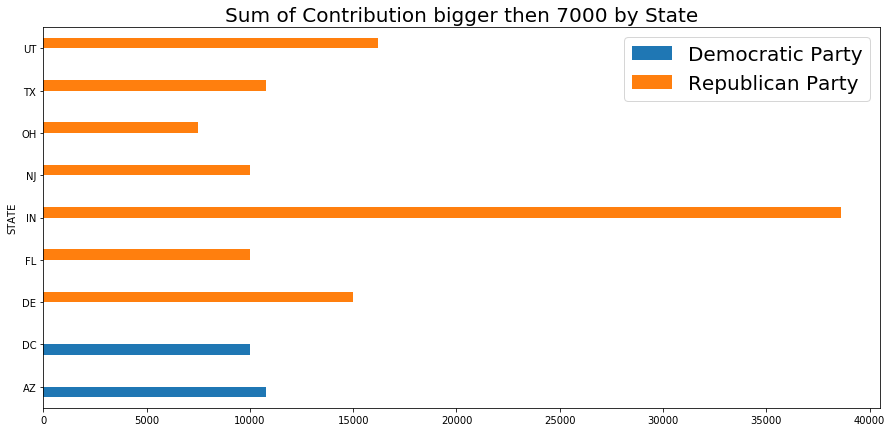

In [536]:
df_big_cont=df_merge[df_merge.Amount>7000]
ax = df_big_cont.groupby(['PARTY', 'STATE']).Amount.sum().unstack(0).plot.barh(figsize=(15,7))
ax.set_title('Sum of Contribution bigger then 7000 by State', fontsize=20)
plt.legend( loc='upper right',fontsize=20)

* Is employer correlated with Party ?
Plot transaction sum per party of the 10 largest values in Employer column.

Text(0.5,1,'Sum of Contribution bigger then 7000 by State')

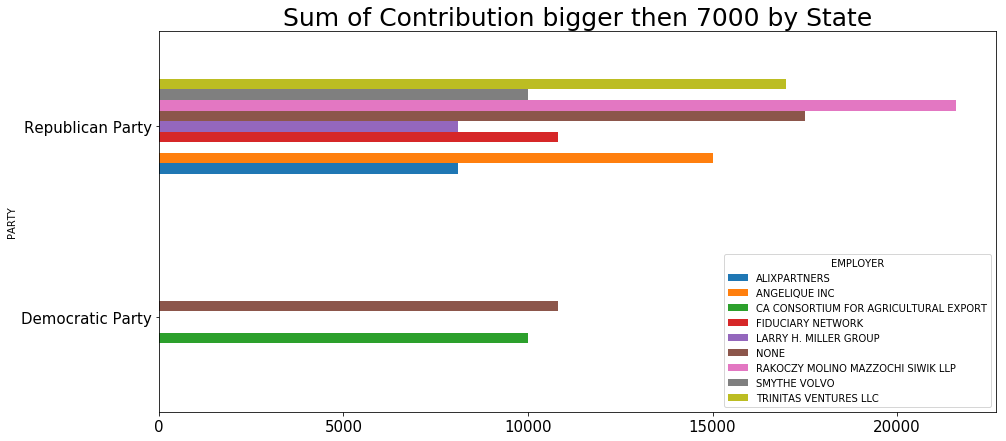

In [537]:

df_big_cont=df_merge[df_merge.Amount>7000]
ax = df_big_cont.groupby(['EMPLOYER', 'PARTY']).Amount.sum().unstack(0)[0:10].plot.barh(fontsize=15,
                                                                                        figsize=(15,7))
ax.set_title('Sum of Contribution bigger then 7000 by State', fontsize=25)


In [538]:
df_merge['Date'].min()

Timestamp('2016-04-28 00:00:00')

In [539]:
min_date = pd.datetime(year=2017,month=3,day=1)
max_date = pd.datetime(year=2018,month=10,day=31)
df_merge=df_merge[(df_merge['Date'] >= min_date) & (df_merge['Date'] <= max_date)]


In [540]:
df_merge.describe()

,Amount,Work
count,20375.000000,20375.000000
mean,437.551362,0.794994
std,795.851666,0.403716
min,1.000000,0.000000
25%,25.000000,1.000000
50%,100.000000,1.000000
75%,500.000000,1.000000
max,15000.000000,1.000000


## Explore Contribution Amount Time series
To plot daily contribution amount time series, Group contribution by date, and sum. 

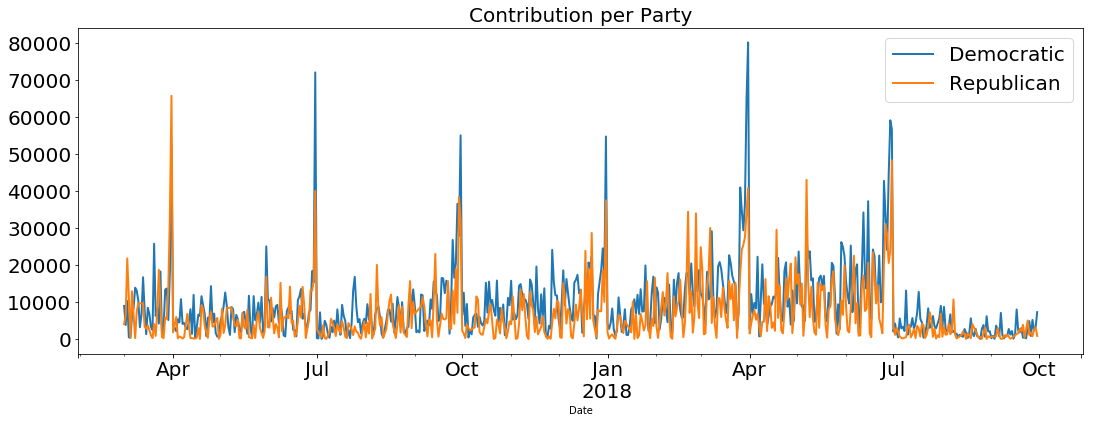

In [541]:
fig = plt.figure(figsize=(18,6))
ax = fig.gca()
for n in df_merge.PARTY.unique():
    df_merge[df_merge['PARTY']==n].groupby('Date').Amount.sum().plot(linewidth=2, fontsize=20)

ax.set_title('Contribution per Party',fontsize=20)
plt.legend(['Democratic', 'Republican'], loc='best',fontsize=20)

### Visualize Trend - rolling mean
To visualize trend, we plot the rolling mean of the transaction amount, summed daily.

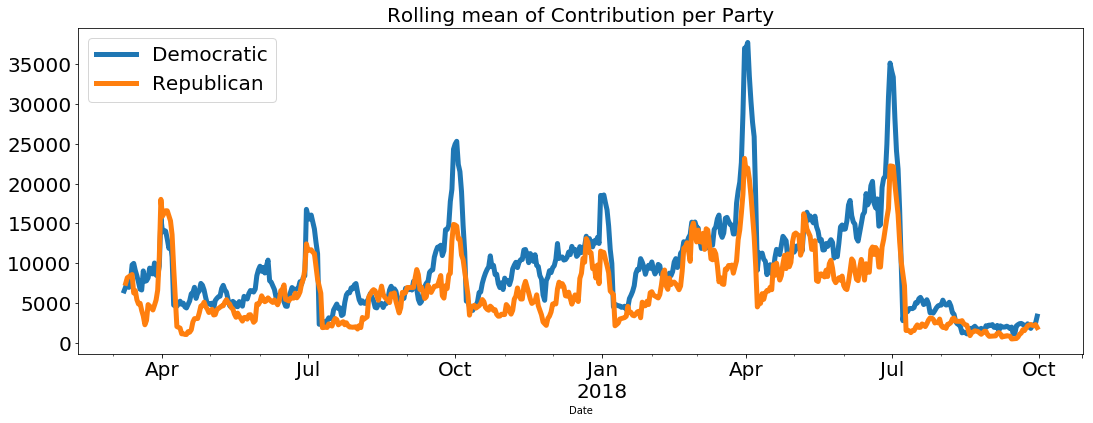

In [542]:
fig = plt.figure(figsize=(18,6))
ax = fig.gca()

df_merge[df_merge.PARTY_CODE=='DEM'].groupby('Date').Amount.sum().rolling(8).mean().plot(linewidth=5, fontsize=20)
df_merge[df_merge.PARTY_CODE=='REP'].groupby('Date').Amount.sum().rolling(8).mean().plot(linewidth=5, fontsize=20)

ax.set_title('Rolling mean of Contribution per Party',fontsize=20)
plt.legend(['Democratic', 'Republican'], loc='best',fontsize=20)

### Visualize Seasonality - First difference
To visualize seasonality, we remove the trend using  Pandas method to compute and plot the first order difference of the contribution amount.

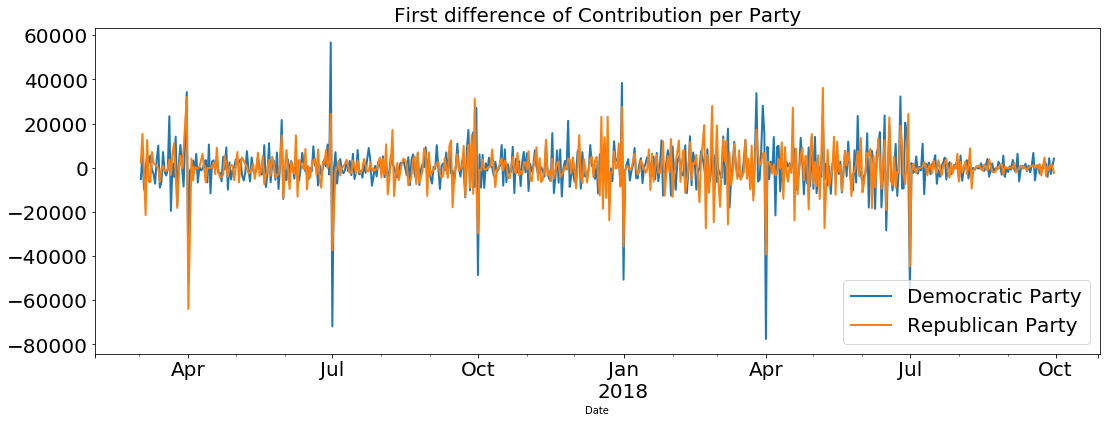

In [544]:
fig = plt.figure(figsize=(18,6))
ax = fig.gca()
for n in df_merge.PARTY.unique():
    df_merge[df_merge['PARTY']==n].groupby('Date').Amount.sum().diff().plot(linewidth=2, fontsize=20)

ax.set_title('First difference of Contribution per Party',fontsize=20)
plt.legend(df_merge.PARTY.unique(), loc='lower right',fontsize=20)

## Next Steps
Many more aggregation and exploration can be done on this data.<br>
An interesting project will be to download historical contribution data from previous election cycle, and look for features correlated with winning the elections, to try and predict, the current winners in the upcoming election.